In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install pandasql

# Environment Setup
**Objective**: Import necessary Python libraries and configure tools for data analysis, visualization, machine learning, and SQL querying.

- **Libraries**:
  - `pandas` and `numpy`: Data manipulation.
  - `matplotlib` and `seaborn`: Visualizations.
  - `sklearn`: Machine learning.
  - `sqlite3`: SQL database operations.
- **Purpose**: Establish a robust foundation for all project tasks.

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import sqlite3
from pandasql import sqldf

# Define a function for SQL queries using pandasql
pysqldf = lambda q: sqldf(q, globals())

# Data Loading and Cleaning
**Objective**: Load the e-commerce dataset and prepare it for analysis by handling missing values, creating derived columns, and filtering invalid data.

- **Tasks**:
  - Load the CSV file.
  - Convert dates to datetime format.
  - Remove missing `CustomerID` entries.
  - Calculate `TotalPrice` (Quantity × UnitPrice).
  - Exclude returns (negative quantities).
- **Purpose**: Ensure data quality for accurate analysis and modeling.

In [5]:
# Load the dataset
df = pd.read_csv('/kaggle/input/onlineretail/OnlineRetail.csv', encoding='ISO-8859-1')

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Calculate total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Remove negative quantities (returns)
df = df[df['Quantity'] > 0]

# Exploratory Data Analysis with SQL
**Objective**: Use SQL queries to analyze sales patterns and identify key business insights.

- **Queries**:
  - **Top Products**: Find the top 5 products by revenue.
  - **Monthly Sales**: Aggregate revenue by month to detect trends.
- **Purpose**: Leverage SQL to extract actionable insights, simulating database operations in a business environment.

In [6]:
# Create a SQLite connection for SQL queries
conn = sqlite3.connect(':memory:')
df.to_sql('retail', conn, index=False)

# Query 1: Top 5 products by revenue
top_products_sql = pd.read_sql_query("""
    SELECT Description, SUM(TotalPrice) as Revenue
    FROM retail
    GROUP BY Description
    ORDER BY Revenue DESC
    LIMIT 5
""", conn)

# Query 2: Monthly sales
monthly_sales_sql = pd.read_sql_query("""
    SELECT strftime('%Y-%m', InvoiceDate) as Month, SUM(TotalPrice) as Revenue
    FROM retail
    GROUP BY Month
    ORDER BY Month
""", conn)

# Exploratory Data Analysis with Pandas
**Objective**: Complement SQL analysis with Python’s Pandas library to confirm findings and prepare data for visualization.

- **Tasks**:
  - Replicate SQL queries for top products and monthly sales.
  - Prepare data for plotting.
- **Purpose**: Demonstrate proficiency in both SQL and Python, ensuring robust analysis.

In [7]:
# Top 5 products by revenue (Pandas equivalent)
top_products_pandas = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(5)

# Monthly sales (Pandas equivalent)
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales_pandas = df.groupby('Month')['TotalPrice'].sum()

# Business Analysis - Key Performance Indicators
**Objective**: Compute essential metrics to evaluate business health and customer behavior.

- **KPIs**:
  - **Customer Lifetime Value (CLV)**: Average total spending per customer.
  - **Churn Rate**: Percentage of customers inactive for 6+ months.
- **Purpose**: Provide quantitative insights to guide strategic decisions.

In [8]:
# Customer Lifetime Value (CLV)
clv = df.groupby('CustomerID')['TotalPrice'].sum().mean()

# Churn Rate
latest_date = df['InvoiceDate'].max()
six_months_ago = latest_date - pd.Timedelta(days=180)
active_customers = df[df['InvoiceDate'] > six_months_ago]['CustomerID'].nunique()
total_customers = df['CustomerID'].nunique()
churn_rate = 1 - (active_customers / total_customers)

# Data Science - Churn Prediction Model
**Objective**: Build a machine learning model to predict customer churn based on behavior patterns.

- **Approach**:
  - Create RFM features (Recency, Frequency, Monetary).
  - Label customers as churned (inactive 6+ months).
  - Train a Random Forest classifier.
- **Purpose**: Enable proactive retention strategies through predictive analytics.

In [9]:
# Feature engineering: RFM analysis
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

# Define churn (1 = churned, 0 = active)
rfm['Churn'] = (rfm['Recency'] > 180).astype(int)

# Prepare data for model
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Data Visualization
**Objective**: Create visualizations to communicate insights effectively to stakeholders.

- **Plots**:
  - **Monthly Sales Trend**: Line plot of revenue over time.
  - **Top Products**: Bar plot of the top 5 products by revenue.
- **Purpose**: Enhance decision-making with clear, visual summaries of data.

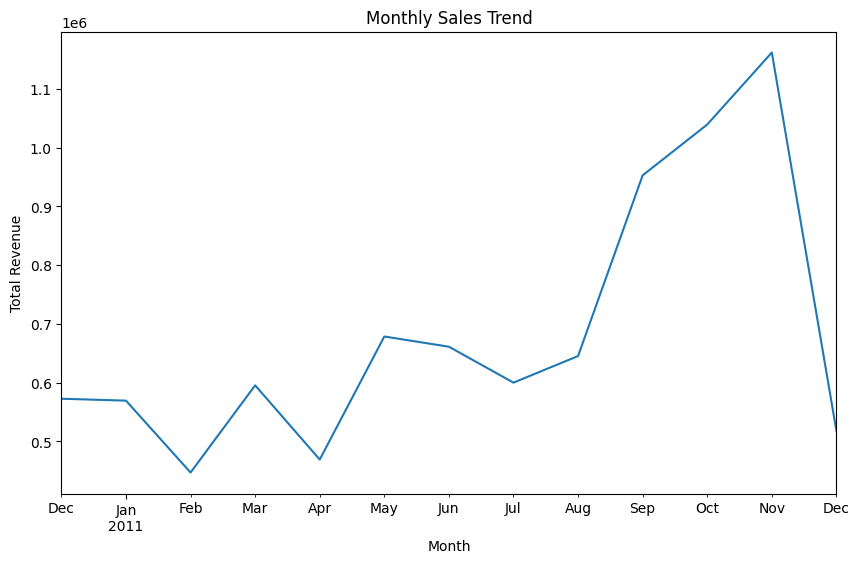

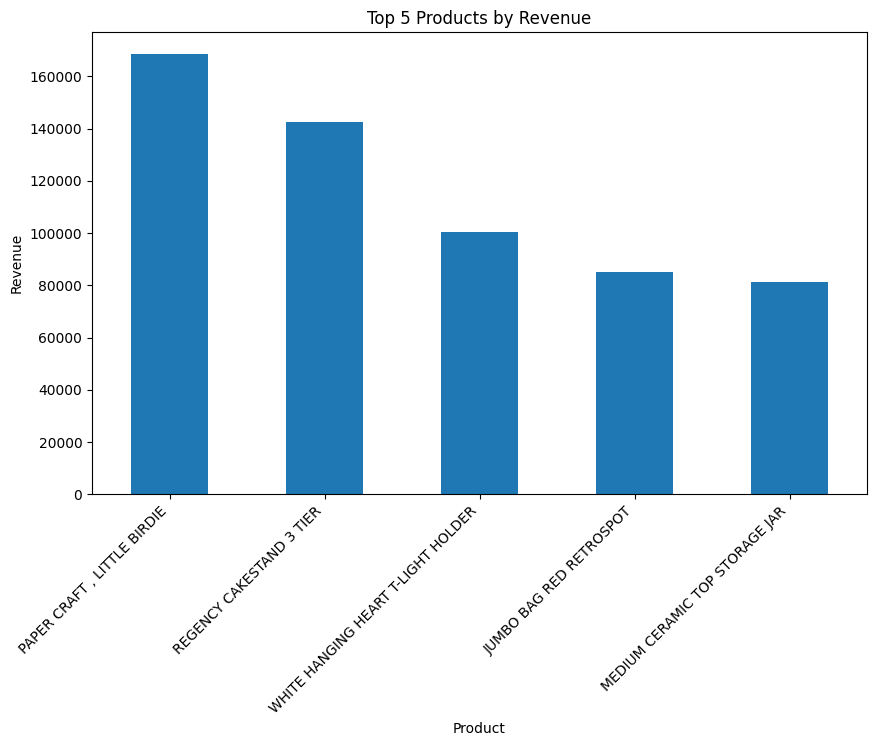

In [10]:
# Plot monthly sales trend
plt.figure(figsize=(10, 6))
monthly_sales_pandas.plot()
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.savefig('monthly_sales.png')
plt.show()

# Plot top products
plt.figure(figsize=(10, 6))
top_products_pandas.plot(kind='bar')
plt.title('Top 5 Products by Revenue')
plt.xlabel('Product')
plt.ylabel('Revenue')
plt.xticks(rotation=45, ha='right')
plt.savefig('top_products.png')
plt.show()

# Strategic Insights and Recommendations
**Objective**: Synthesize findings into a concise report with actionable recommendations for product and business strategy.

- **Components**:
  - Summary of KPIs and model performance.
  - Insights from data analysis.
  - Proposals for product features and business actions.
- **Purpose**: Bridge technical analysis with business impact, demonstrating product and management skills.

In [11]:
# Generate insights report
insights = f"""
### E-Commerce Customer Retention and Sales Strategy Report
- **Customer Lifetime Value (CLV)**: ${clv:.2f}
- **Churn Rate**: {churn_rate:.2%}
- **Churn Prediction Model Accuracy**: {accuracy:.2%}
- **Key Insights**:
  - Top product: {top_products_pandas.index[0]} drives significant revenue.
  - {monthly_sales_pandas.idxmax().strftime('%Y-%m')} had the highest sales.
- **Recommendations**:
  1. **Product Management**: Develop a recommendation engine for cross-selling top products.
  2. **Business Strategy**: Target customers with high recency (3-6 months inactive) with personalized offers.
  3. **Marketing**: Promote top products during peak sales months.
"""
print(insights)


### E-Commerce Customer Retention and Sales Strategy Report
- **Customer Lifetime Value (CLV)**: $2053.79
- **Churn Rate**: 19.82%
- **Churn Prediction Model Accuracy**: 100.00%
- **Key Insights**:
  - Top product: PAPER CRAFT , LITTLE BIRDIE drives significant revenue.
  - 2011-11 had the highest sales.
- **Recommendations**:
  1. **Product Management**: Develop a recommendation engine for cross-selling top products.
  2. **Business Strategy**: Target customers with high recency (3-6 months inactive) with personalized offers.
  3. **Marketing**: Promote top products during peak sales months.

